# Dataset 4 - Boston

## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../src')
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import bostonDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 13
n_samples= 506
 
#ABC Generator Parameters
mean = 1 
variance = 0.001

## Dataset

Generate a random regression problem

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [4]:
X,Y = bostonDataset.boston_data()

        X1    X2    X3   X4     X5     X6    X7      X8   X9    X10   X11  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

      X12   X13     Y  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 11 Nov 2021   Prob (F-statistic):          6.72e-135
Time:                        18:23:25   Log-Likelihood:                -376.55
No. Observations:                 506   AIC:                             781.1
Df Residuals:                     492   BIC:                             840.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.749e-15      0.023  -7.62e-14      1.0

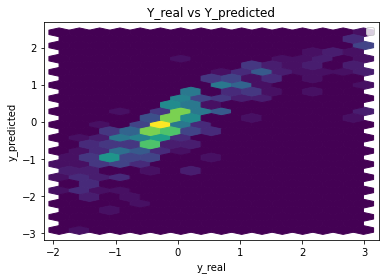

Performance Metrics
Mean Squared Error: 0.2593573358905904
Mean Absolute Error: 0.3559924576478398
Manhattan distance: 180.13218356980698
Euclidean distance: 11.455776357830963


In [5]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [30]:
n_epochs = 1000
threshold = 1
batch_size = n_samples

## GAN Model

In [7]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
import pycuda.driver as cuda
cuda.init()
## Get Id of default device
torch.cuda.current_device()
# 0
cuda.Device(0).name()

'GeForce GTX 1660 Ti'

**Training GAN for n_epochs number of epochs** 

In [31]:
generator = network.Generator(n_features+2).to(device)
discriminator = network.Discriminator(n_features+2).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [32]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=15, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=15, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [33]:
discLossG1,genLossG1 = train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

In [34]:
GAN1_metrics = train_test.test_generator(generator,real_dataset,device)

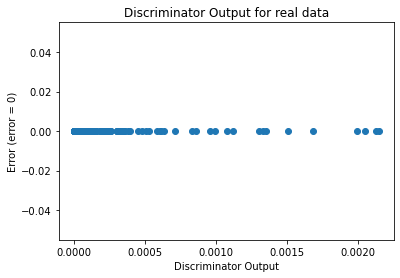

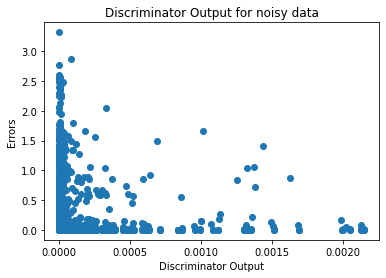

In [35]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [36]:
generator2 = network.Generator(n_features+2).to(device)
discriminator2 = network.Discriminator(n_features+2).to(device)
criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [37]:
discLossG2,genLossG2 = train_test.training_GAN_2(discriminator2,generator2,disc_opt,gen_opt,real_dataset,batch_size,threshold,criterion,device)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper___cat)

In [17]:
GAN2_metrics=train_test.test_generator_2(generator2,real_dataset,device)

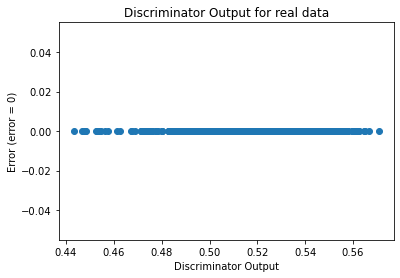

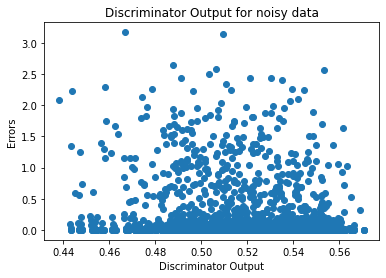

In [18]:
sanityChecks.discProbVsError(real_dataset,discriminator2,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [19]:
gen = network.Generator(n_features+2).to(device)
disc = network.Discriminator(n_features+2).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [20]:
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper___cat)

In [21]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

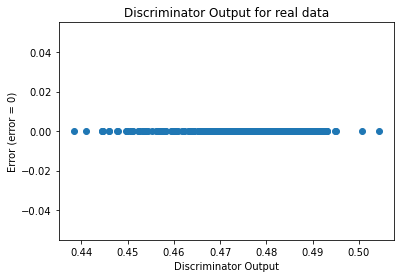

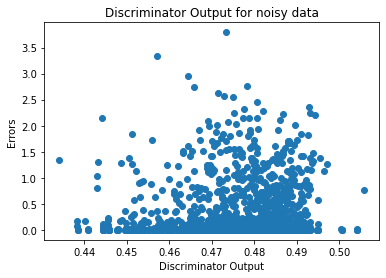

In [22]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [23]:
gen2 = network.Generator(n_features+2).to(device)
disc2 = network.Discriminator(n_features+2).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [25]:
discLossA2,genLossA2 = ABC_train_test.training_GAN_3(disc2,gen2,disc_opt,gen_opt,real_dataset,batch_size,threshold,criterion,coeff,mean,variance,device)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper___cat)

In [26]:
ABC_GAN2_metrics=ABC_train_test.test_generator_2(gen2,real_dataset,coeff,mean,variance,device)

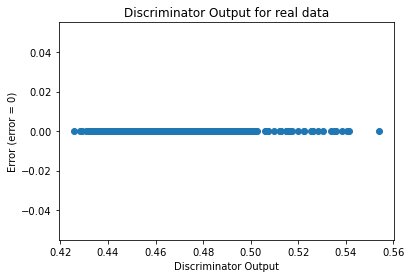

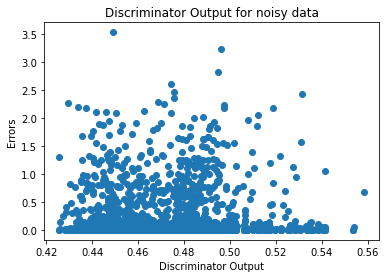

In [27]:
sanityChecks.discProbVsError(real_dataset,disc2,device)

# Model Analysis

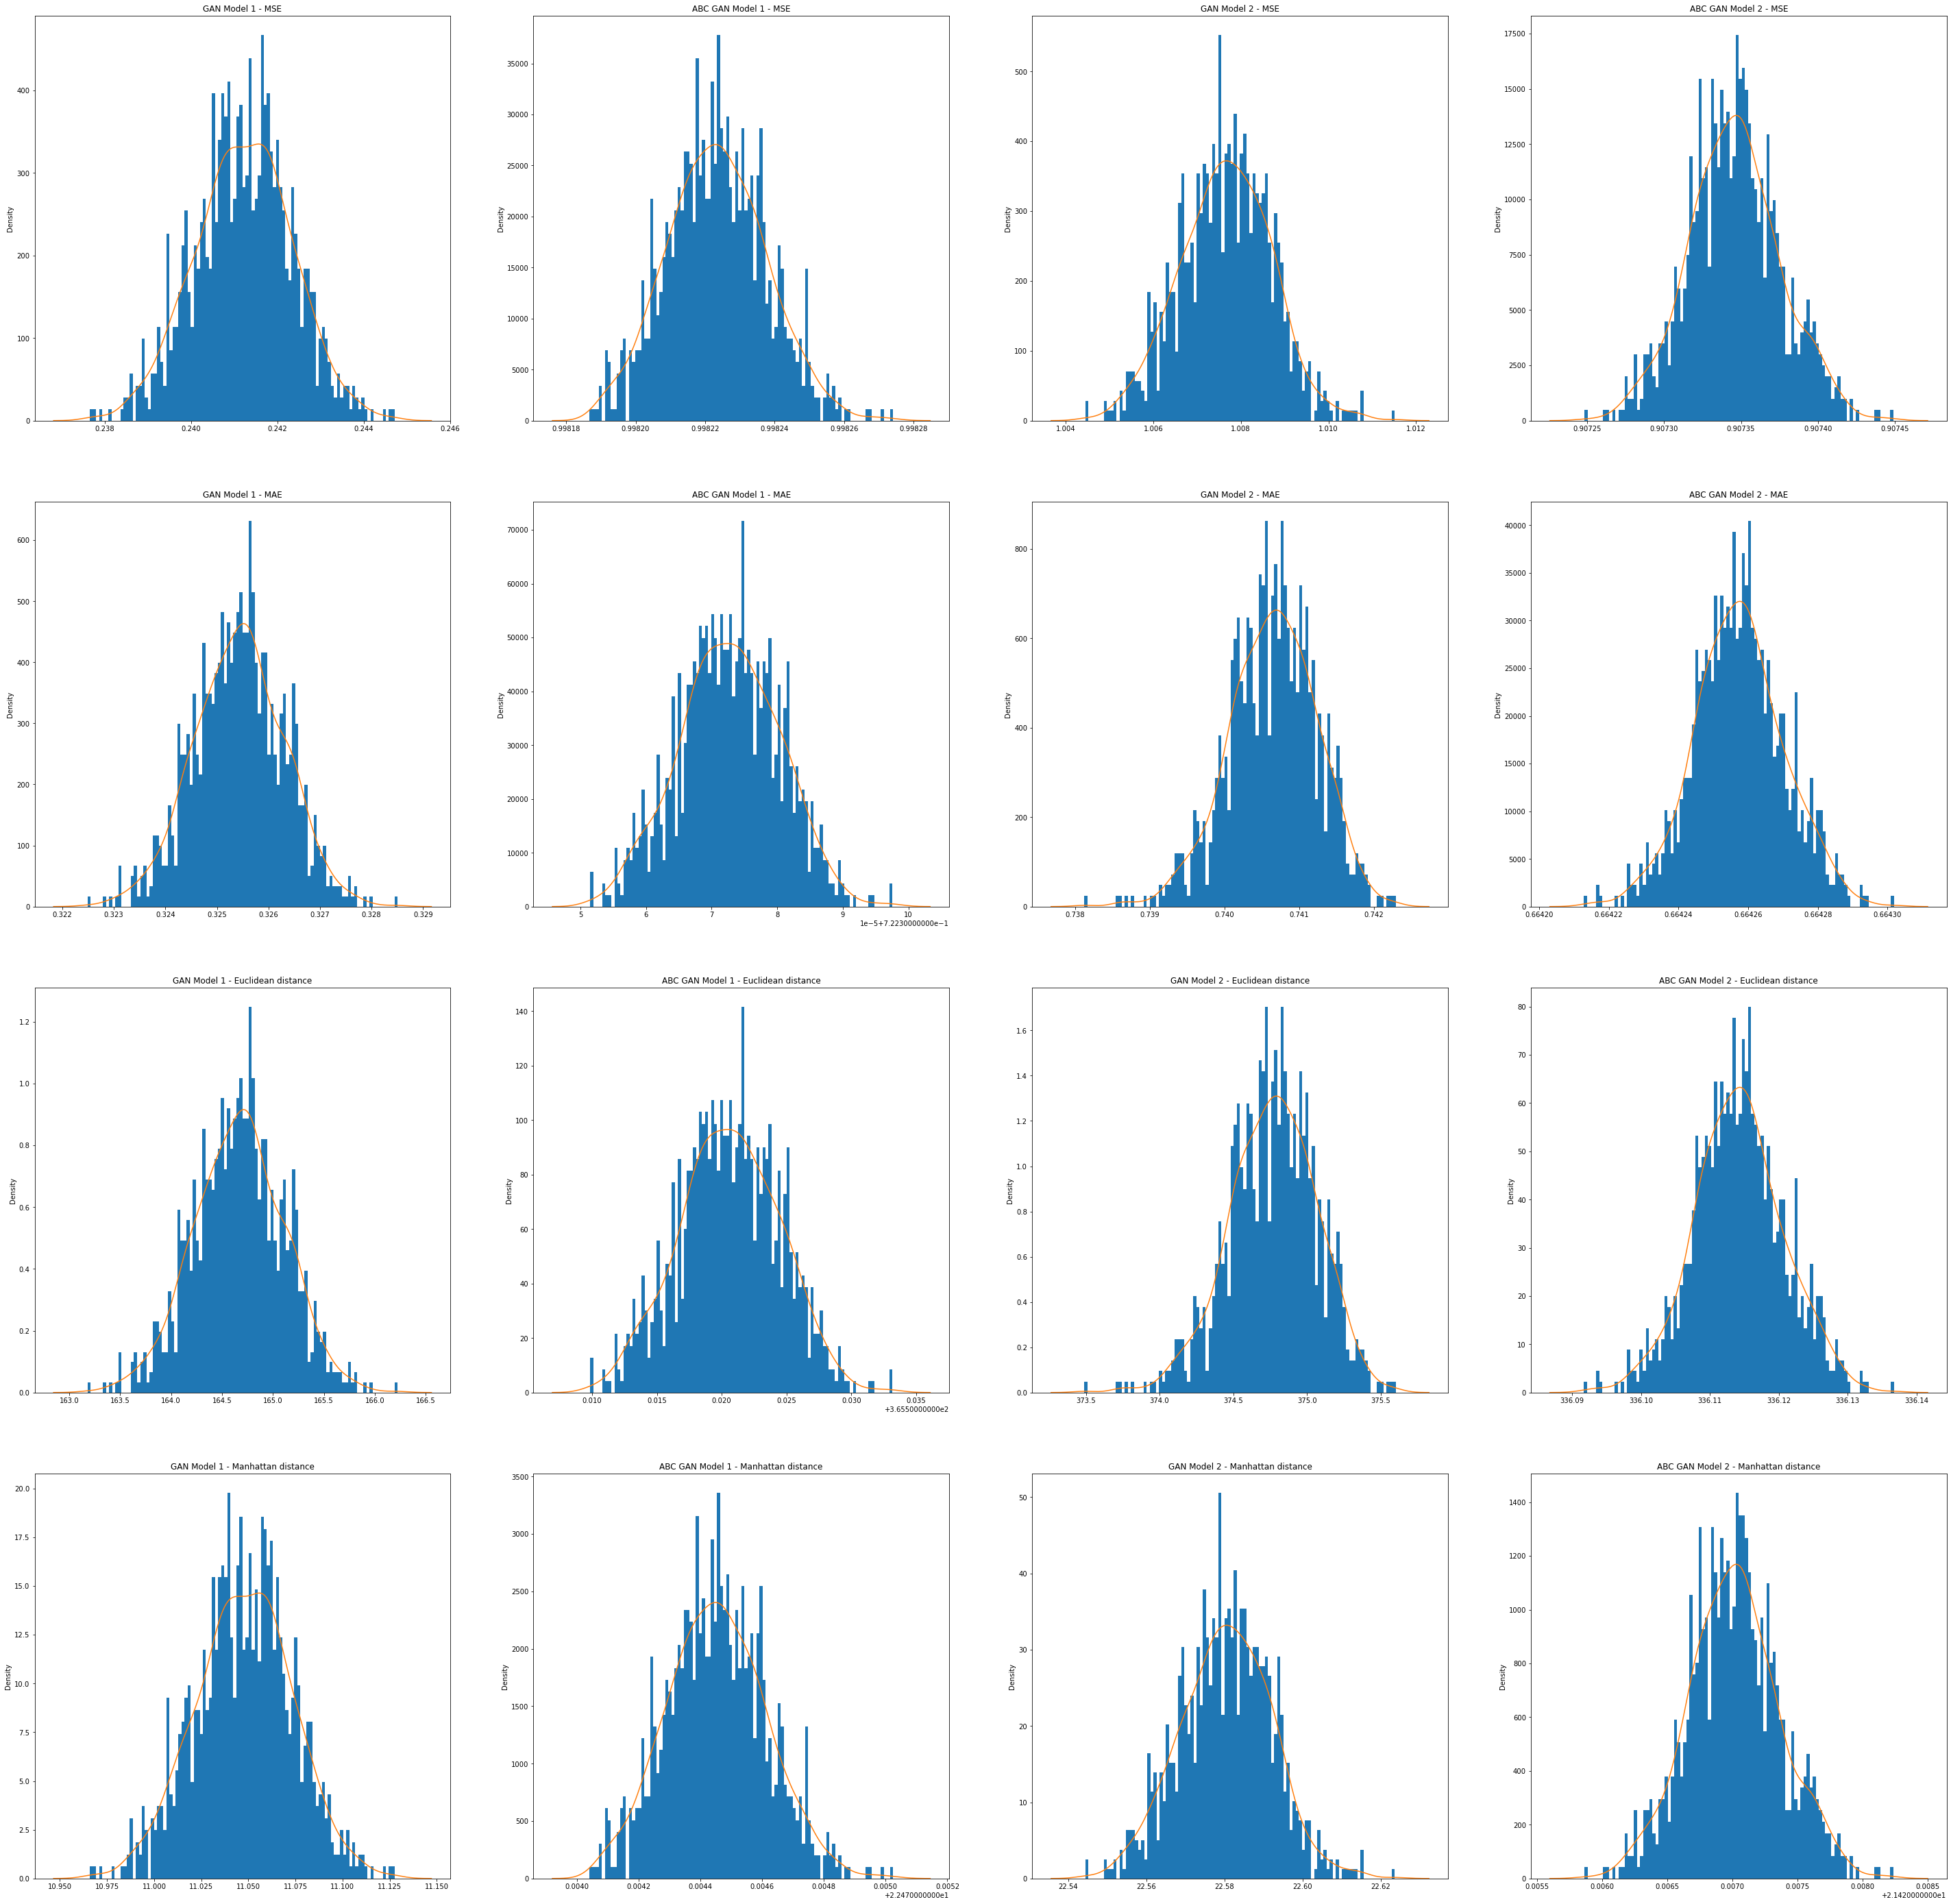

In [28]:
performanceMetrics.modelAnalysis(GAN1_metrics,ABC_GAN1_metrics,GAN2_metrics,ABC_GAN2_metrics)

In [29]:
performanceMetrics.plotTrainingLoss(discLossG1,genLossG1,discLossA1,genLossA1,discLossG2,genLossG2,discLossA2,genLossA2)

NameError: name 'discLossA1' is not defined